In [1]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("max_colwidth", 200)

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import os.path
import fuzzywuzzy as fz
import googletrans as gtr
import translate as tr
import langdetect as ld
import scipy as sp

os.getcwd()

from hyperopt import hp

import optuna

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

from sklearn.dummy import DummyRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from numpy import asarray

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import datasets

import timeit

from sklearn import metrics

import lime.lime_tabular

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from sklearn import decomposition


# Import et nettoyage de la database

In [2]:
df1 = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')


In [3]:
df1.shape

(1050, 15)

In [4]:
List_col=list(df1.columns)

In [5]:
df1.isna().sum()

# no nan on key values (uniq_id, image, product_name,...)

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [6]:
df1.drop_duplicates()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value""=>""Flat""}, {""key""=>""Material"", ""value""=>""Cotton""}..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-

In [7]:
df1.shape

(1050, 15)

In [8]:
for i in List_col:
    df1_doublons=df1[i].value_counts().rename_axis('unique_values').to_frame('counts')
    if df1_doublons['counts'].mean()!=1:
        print(i)
        print(round(df1_doublons['counts'].mean()))



crawl_timestamp
7
product_category_tree
2
retail_price
3
discounted_price
2
is_FK_Advantage_product
525
product_rating
39
overall_rating
39
brand
1
product_specifications
1


In [9]:
# multiple values : ok, key values are not in double (uniq_id, product_name,..)

# Extraire les clusters dans "product_category_tree"

In [10]:
import re

L=[]

for i in df1['product_category_tree']:
    a=i.split(">>")
    text=a[0]
    text = re.sub(r'&', 'and', text) # remove punc.
    text = re.sub(r'[^\w\s]', ' ', text) # remove punc.
    text = re.sub('^\s+|\s+$', '', text); # remove spaces
    #text = re.sub('/\s{2,}/g', '', text)
    text
    L.append(text)

df1['Category']=L

In [11]:
df1['Category'].value_counts()

Beauty and Personal Care        150
Home Furnishing                 150
Computers                       150
Kitchen and Dining              150
Home Decor and Festive Needs    150
Watches                         150
Baby Care                       150
Name: Category, dtype: int64

In [12]:
# 7 clusters

In [13]:
df1['product_category_tree'][10]

'["Watches >> Wrist Watches >> Calibro Wrist Watches"]'

# Text mining :

In [14]:
# to improve our model, we can use : 
## bigrams (did not, more than 'did' and 'not')
## genders
## contexts
## sentiments --> not here 

# to reduce dimensionality :
## group synonym (synset)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence




## REGEX to clean data 

In [15]:
import re

Regex_sentences=[]

sentence_1=df1['description'][0]

for x in df1['description'] :

    new_text = re.sub('<.*?>', ' ', x)   # remove HTML tags
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # remove punc.
    new_text = re.sub(r'\d+',' ',new_text)# remove numbers
    new_text = new_text.lower() # lower case, .upper() for upper          

    Regex_sentences.append(new_text)


In [16]:
len(Regex_sentences)

1050

## Tokenization :

In [17]:
from keras.preprocessing.text import Tokenizer
# define documents
docs = Regex_sentences

# create the tokenizer
t = Tokenizer()

# fit the tokenizer on the documents
t.fit_on_texts(docs)

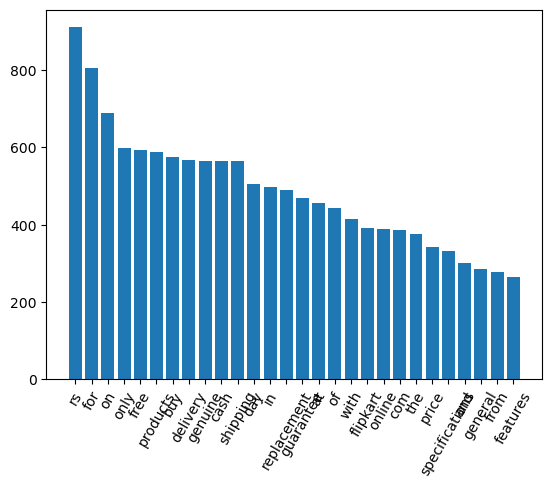

In [19]:
# filtered dict :

def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict


newDict = filterTheDict(t.word_docs, lambda elem: elem[1] > 250)

new_Dict_ordered={k: v for k, v in sorted(newDict.items(), key=lambda item: item[1],reverse=True)}

keys = new_Dict_ordered.keys()
values = new_Dict_ordered.values()


plt.bar(range(len(new_Dict_ordered)), list(new_Dict_ordered.values()), align='center')
plt.xticks(range(len(new_Dict_ordered)), list(new_Dict_ordered.keys()))


plt.tick_params(axis = 'x', rotation = 60)
plt.show()

## Stopwords

In [21]:
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())

In [22]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 

 
#stop_words = set(stopwords.words('english'))

filtered_Regex_sentences=[]

count=0
list_sw=[]
liste_des_mots = []

for j in range(len(Regex_sentences)):
    word_tokens = word_tokenize(Regex_sentences[j])
 
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
 
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
        if w not in stop_words and w not in liste_des_mots:
            liste_des_mots.append(w)
        elif w in stop_words and w not in list_sw :
            count=count+1
            list_sw.append(w)
    
    filtered_Regex_sentences.append(filtered_sentence)            
        
 


#print(word_tokens)
#print(filtered_sentence)

In [23]:
len(liste_des_mots)

4765

In [24]:
count

467

In [25]:
liste_mots_tot=[]
for i in range(len(filtered_Regex_sentences)):
    for j in range(len(filtered_Regex_sentences[i])):
        mot=filtered_Regex_sentences[i][j]
        liste_mots_tot.append(mot)

In [26]:
list_occur=[]
for i in range(len(liste_mots_tot)):
    x = liste_mots_tot.count(i)
    list_occur.append(x)


## Lemmatization :

In [27]:
# import these modules
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
  
    
lemmatizer = WordNetLemmatizer()

filtered_lemmatized_Regex_sentences=[]

# choose some words to be lemmatized
for k in range(len(filtered_Regex_sentences)):
    
    words = filtered_Regex_sentences[k]
    lemmatized = []
    
    for w in words:
        lemmatizer.lemmatize(w)
        lemmatized.append(lemmatizer.lemmatize(w))
    
    filtered_lemmatized_Regex_sentences.append(lemmatized)
        

In [28]:
len(filtered_lemmatized_Regex_sentences)

1050

In [29]:
new_corpus=[]

for i in range(len(filtered_lemmatized_Regex_sentences)):
    for j in filtered_lemmatized_Regex_sentences[i]:
        if j not in new_corpus :
            new_corpus.append(j)

In [30]:
len(new_corpus)

4383

## Transform tokens to sentences :



In [33]:
filtered_lemmatized_Regex_sentences[0][0]

'key'

In [34]:
List_sentences=[]
for i in range(len(filtered_lemmatized_Regex_sentences)):
    sentence=''
    for j in range(len(filtered_lemmatized_Regex_sentences[i])):
        sentence = sentence + ' ' + filtered_lemmatized_Regex_sentences[i][j]
    List_sentences.append(sentence)

In [35]:
filtered_lemmatized_Regex_sentences[0][0] + ' ' + filtered_lemmatized_Regex_sentences[0][1]

'key feature'

## Second delete of stop words to enhance modelization :


In [57]:
docs = List_sentences
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

In [230]:
import nltk

freq_totale = nltk.Counter()

for k, v in print(t.word_docs).iteritems():
    freq_totale += freq[k]

defaultdict(<class 'int'>, {'floral': 39, 'environment': 4, 'morning': 15, 'sale': 219, 'filter': 1, 'set': 161, 'dimension': 149, 'draw': 3, 'romantic': 1, 'elegance': 6, 'heart': 3, 'room': 32, 'softly': 1, 'door': 18, 'special': 26, 'contemporary': 12, 'feature': 267, 'package': 218, 'shrinkage': 3, 'bring': 20, 'stitch': 2, 'fabric': 116, 'smoothly': 3, 'content': 146, 'high': 64, 'apparance': 1, 'specification': 333, 'valance': 1, 'attention': 4, 'style': 83, 'abstract': 44, 'surreal': 1, 'design': 149, 'good': 26, 'body': 69, 'box': 251, 'brand': 207, 'general': 284, 'enhances': 6, 'material': 206, 'type': 237, 'price': 542, 'print': 54, 'wrinkle': 2, 'joyous': 1, 'slide': 2, 'pack': 207, 'moment': 7, 'bright': 9, 'loving': 1, 'key': 202, 'soothing': 3, 'multicolor': 87, 'ring': 5, 'polyester': 28, 'close': 1, 'number': 218, 'eyelet': 19, 'steal': 1, 'curtain': 21, 'height': 88, 'designed': 54, 'evening': 3, 'duster': 1, 'ray': 3, 'quality': 106, 'ant': 3, 'appeal': 7, 'sun': 4, 

AttributeError: 'NoneType' object has no attribute 'iteritems'

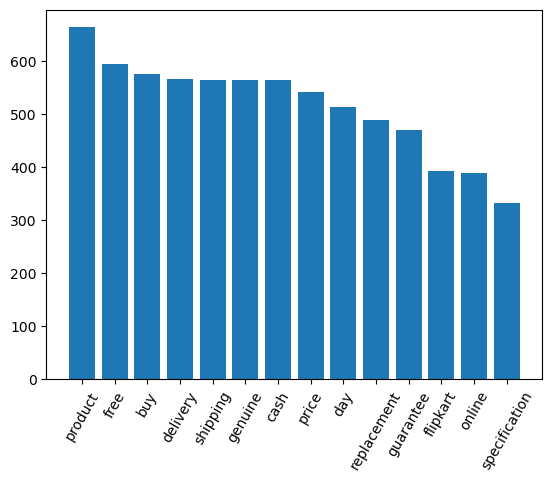

In [231]:
# filtered dict :

def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict


newDict = filterTheDict(t.word_docs, lambda elem: elem[1] > 300)

new_Dict_ordered={k: v for k, v in sorted(newDict.items(), key=lambda item: item[1],reverse=True)}

keys = new_Dict_ordered.keys()
values = new_Dict_ordered.values()


plt.bar(range(len(new_Dict_ordered)), list(new_Dict_ordered.values()), align='center')
plt.xticks(range(len(new_Dict_ordered)), list(new_Dict_ordered.keys()))


plt.tick_params(axis = 'x', rotation = 60)
plt.show()

In [232]:
liste_supp_stopwords=list(keys)

In [233]:
# suppr stopwords suivant données du graphe ci-dessus

filtered_Regex_sentences_2=[]

for j in range(len(List_sentences)):
    word_tokens = word_tokenize(List_sentences[j])
 
    filtered_sentence = [w for w in word_tokens if not w.lower() in liste_supp_stopwords]
 
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in liste_supp_stopwords:
            filtered_sentence.append(w)
    
    
    filtered_Regex_sentences_2.append(filtered_sentence)            
        
 


#print(word_tokens)
#print(filtered_sentence)

In [234]:
List_sentences_2=[]
for i in range(len(filtered_Regex_sentences_2)):
    sentence=''
    for j in range(len(filtered_Regex_sentences_2[i])):
        sentence = sentence + ' ' + filtered_Regex_sentences_2[i][j]
    List_sentences_2.append(sentence)

## tf idf :

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
texts = List_sentences
cv.fit(texts)
#print ("Taille: {}",  len (cv.vocabulary_))
#print ("Contenu: {}",  cv.vocabulary_)

CountVectorizer()

In [37]:
bow = cv.transform(texts)
print ("Sac de mots: {}", bow)
sdm = bow.toarray()


Sac de mots: {}   (0, 25)	4
  (0, 157)	1
  (0, 161)	1
  (0, 173)	1
  (0, 175)	1
  (0, 246)	1
  (0, 349)	1
  (0, 430)	1
  (0, 463)	1
  (0, 471)	1
  (0, 487)	2
  (0, 496)	1
  (0, 724)	1
  (0, 761)	1
  (0, 848)	1
  (0, 850)	1
  (0, 923)	1
  (0, 961)	11
  (0, 1056)	2
  (0, 1057)	1
  (0, 1097)	1
  (0, 1149)	5
  (0, 1160)	2
  (0, 1199)	1
  (0, 1254)	4
  :	:
  (1048, 2417)	2
  (1048, 2687)	1
  (1048, 3016)	1
  (1048, 3041)	1
  (1048, 3247)	1
  (1048, 3516)	1
  (1048, 3746)	4
  (1048, 4193)	2
  (1048, 4227)	2
  (1049, 541)	1
  (1049, 607)	1
  (1049, 998)	1
  (1049, 1033)	1
  (1049, 1562)	1
  (1049, 1636)	1
  (1049, 1733)	1
  (1049, 2175)	2
  (1049, 2687)	1
  (1049, 3016)	1
  (1049, 3041)	1
  (1049, 3247)	1
  (1049, 3516)	1
  (1049, 3746)	2
  (1049, 4090)	2
  (1049, 4193)	2


In [38]:
#CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
#                           stop_words='english')

#transform
Count_data = cv.fit_transform(texts)
 
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=cv.get_feature_names())


In [39]:
#with smooth
#tf_idf_vec_smooth = TfidfVectorizer(use_idf=True,  
#                        smooth_idf=True,  
#                        ngram_range=(1,1),stop_words='english')


tf_idf_vec_smooth = TfidfVectorizer(use_idf=True,  
                        smooth_idf=True)

tf_idf_vec_smooth_bigramm = TfidfVectorizer(use_idf=True,  
                            smooth_idf=True, ngram_range=(2,2))

 
tf_idf_data_smooth = tf_idf_vec_smooth.fit_transform(texts)

tf_idf_data_smooth_bigramm = tf_idf_vec_smooth_bigramm.fit_transform(texts)

 
print("With Smoothing:")
tf_idf_dataframe_smooth = pd.DataFrame(tf_idf_data_smooth.toarray(),columns=tf_idf_vec_smooth.get_feature_names())
tf_idf_dataframe_smooth

tf_idf_dataframe_smooth_bigramm = pd.DataFrame(tf_idf_data_smooth_bigramm.toarray(),columns=tf_idf_vec_smooth_bigramm.get_feature_names())
#tf_idf_dataframe_smooth_bigramm

tf_idf_dataframe_smooth_bigramm

With Smoothing:


,_b analog,_b online,_blk analog,_c flipkart,_g analog,_g online,_red box,_w analog,_w online,_white_tblue_navy_purple fabric,aa battery,aa pencil,aaa battery,aapno rajasthan,aari embroidered,aari embroidery,aarika design,ability aid,ability lightweight,abkl_grn_grn_grn box,abkl_grn_grn_grn price,abkl_grn_grn_grn soft,abkl_pl_pl_pnk box,abkl_pl_pl_pnk price,abkl_pl_pl_pnk soft,abkl_pl_pnk_pnk box,abkl_pl_pnk_pnk price,abkl_pl_pnk_pnk soft,abode add,abode order,abrasion long,abroad family,absolute comfort,absorbency softness,absorbency towel,absorbent blanket,absorbent dry,absorbent high,absorbent machine,absorbent quick,absorbent type,absorber color,absorbing capacity,absorbs store,abstract abstract,abstract art,abstract ceramic,abstract checkered,abstract color,abstract cushion,abstract design,abstract double,abstract eyelet,abstract floral,abstract geometric,abstract painting,abstract polyester,abstract single,abstract style,abstrcts ceramic,accent flexible,accent uplift,access spacious,access zipexterior,accessory artifact,accessory artificial,accessory battery,accessory box,accessory clip,accessory component,accessory embellishment,accessory feature,accessory filled,accessory golden,accessory ready,accessory replicate,accessory safely,accessory wall,accessory watch,accessory water,accident customer,accident lightening,accidental damage,accommodate large,accomplishes task,acer aspire,ache pain,aching finger,aci anti,aci model,aci pink,acid cocoamido,acid stearic,acl flipkart,acne facial,acrylic sticker,act deep,active ingredient,actual product,actual set,actual shade,actual size,adaa sitting,adapter assure,adapter charger,adapter conforms,adapter designed,adapter equipped,adapter extender,adapter flipkart,adapter general,adapter high,adapter key,adapter laptop,adapter model,adapter output,adapter pass,adapter pin,adapter power,adapter price,adapter selecting,adapter usb,adapter voltage,adapter year,adaptor month,adaptor pack,adaptor provided,adaptor usb,add appeal,add beautiful,add bling,add cart,add colour,add elegance,add fresh,add kitchen,add oodles,add perfect,add perfectly,add rich,add softness,add spunk,add style,add tea,add touch,add traditional,add vibrancy,addiction rio,adding grace,addition desk,addition décor,addition entertaining,addition exclusive,addition kitchen,addition prayer,additional detail,additional feature,additional trait,additionally dishwasher,adf analog,adf ideal,adhesive number,adhesive pvc,adhesive size,adhesive sticker,adhesive vinyl,adi buddha,adidas dynamic,adidas ice,adidas ready,adidas victory,adino adf,adjust cushioned,adjustable canopy,adjustable dimension,adjustable hour,adjustable number,adjustable shoulder,adjustable size,adjustable sternum,adjustable strap,adjusted press,adjusts fit,admiration guest,admired guest,adorable booty,adorable cute,adorable elephant,adorable fantastic,adorn artwork,adorn dining,adorn gorgeous,adorn shell,adorned traditional,adorning black,adsl modem,adsl port,advance number,advance standard,advice inadvertent,advisable tea,aero care,affect anti,affordable art,affordable mug,affordable price,afternoon siesta,agarwood oud,age fact,age group,ageless copper,aging anti,agrasen international,agrees wallskart,agromech flipkart,agromech special,agromech yiboo,aid concentration,aid filling,aiding concentration,air andriod,air balloon,air bubble,air chair,air cooling,air fan,air flow,air freshener,air lounge,air mb,air vent,airport express,airtel flipkart,airtex dongli,airtex striped,airtex type,airtight capacity,airtight pack,ajmal titanium,akada analog,akada ideal,akshaj lightweight,akup calm,akup ceramic,akup design,akup league,akup life,akup love,alarm general,alarm great,...,woman model,woman navratri,woman neo,woman nosww,woman number,woman occasion,woman olss,woman online,woman organic,woman rk,woman rrtc,woman sd_,woman suitable,woman tm,woman warranty,woman watch,woman ym,wonder amnesia,wonderchef model,wonderchef warranty,wonderchef windsor,wonderful gift,wo

## Singular Value Decomposition (SVD)

In [197]:
from sklearn.decomposition import TruncatedSVD

### Choose the right n_components of truncated SVD

In [198]:
#svd = TruncatedSVD(n_components=1)
#svd.fit(A)
#score=svd.explained_variance_ratio_.sum()

A=tf_idf_data_smooth.copy()

B=tf_idf_data_smooth_bigramm.copy()

score=0
i=1

# dispersion des points dans l'espace
# même avec n_components, on explique à 95% la différence entre les individus

while score<0.95:
    svd = TruncatedSVD(n_components=i)
    svd.fit(A)
    score=svd.explained_variance_ratio_.sum()
    if score>0.95:
        print(i)
        print(score)
    i=i+50

651
0.9513525808331785


In [199]:
svd = TruncatedSVD(n_components=650)

svd.fit(A)

svd.explained_variance_ratio_
svd.explained_variance_ratio_.sum()

0.9508790013339793

In [200]:

result = svd.transform(A)
print(result)


[[ 0.04933291 -0.04806998  0.16437408 ... -0.00305426  0.00218812
   0.02138279]
 [ 0.0785648  -0.02049705  0.24113074 ... -0.05237125 -0.03403384
  -0.043073  ]
 [ 0.08947779 -0.05495339  0.20441011 ...  0.01880402 -0.01822022
  -0.0066524 ]
 ...
 [ 0.12979425 -0.03450203 -0.00986144 ...  0.02290211  0.02651171
   0.00283665]
 [ 0.18116177 -0.05149989 -0.00776007 ...  0.00554492  0.01394268
  -0.00500119]
 [ 0.20956599 -0.05627129 -0.01492199 ... -0.06728538 -0.05822754
   0.01339322]]


## KMeans

In [243]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [244]:

X = result.copy()
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)



# from silhouette_score, best k in n_clusters

kmeans = KMeans(n_clusters=7, random_state=0,init='random').fit(X)


ar = kmeans.predict(X)


df = pd.DataFrame(ar)

df_result=df1.merge(df,on=df1.index,how='left')

df_result.rename(columns={0:'category_KMeans'},inplace=True)


df_result



,key_0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,category_KMeans
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,2
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""...",Baby Care,2
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",...",Baby Care,2
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value""=>""Flat""}, {""key""=>""Material"", ""value""=>""Cotton""}...",Home Furnishing,2
4,4,6325b6870c54cd47be6ebfbffa6

In [245]:
df_result['category_KMeans'].value_counts()

4    381
3    227
1    146
2    139
6     80
5     44
0     33
Name: category_KMeans, dtype: int64

## PCA

In [246]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

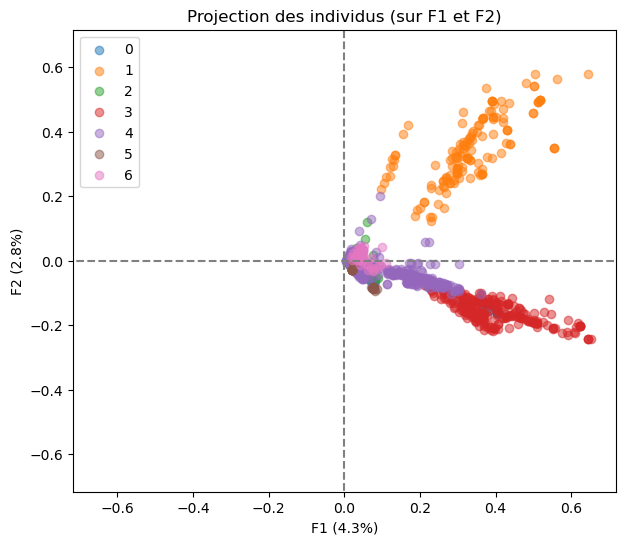

In [247]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=6)
pca.fit(X)


# Category :
category = [df_result.loc[Id, 'category_KMeans'] for Id in df_result.index]

# Eboulis des valeurs propres
#display_scree_plot(pca)

# Projection des individus

centers = kmeans.cluster_centers_

X_projected = pca.transform(X)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = category, alpha = 0.5)

display_factorial_planes(X, 2, pca, [(0,1),(2,3),(4,5)], illustrative_var = category, alpha = 0.5)

## Confusion matrix

In [248]:
df_result.head(1)

,key_0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,category_KMeans
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,2


In [249]:
List_Cat = list(df_result['Category'].unique())
List_Cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor and Festive Needs',
 'Kitchen and Dining',
 'Beauty and Personal Care',
 'Computers']

In [250]:
from sklearn.metrics import confusion_matrix

Category_Name = []

for i in df_result['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result['Category_Name']=Category_Name
    

In [251]:
y_true = df_result['Category_Name']
y_pred = df_result['category_KMeans']
array_cm = confusion_matrix(y_true, y_pred)
array_cm

array([[ 33,   0,   1,  49,  67,   0,   0],
       [  0,   0,  30,   4,  72,  44,   0],
       [  0,   0,  54,  74,  22,   0,   0],
       [  0,   0,  27,   0, 123,   0,   0],
       [  0, 146,   1,   0,   3,   0,   0],
       [  0,   0,  18,  20,  32,   0,  80],
       [  0,   0,   8,  80,  62,   0,   0]], dtype=int64)

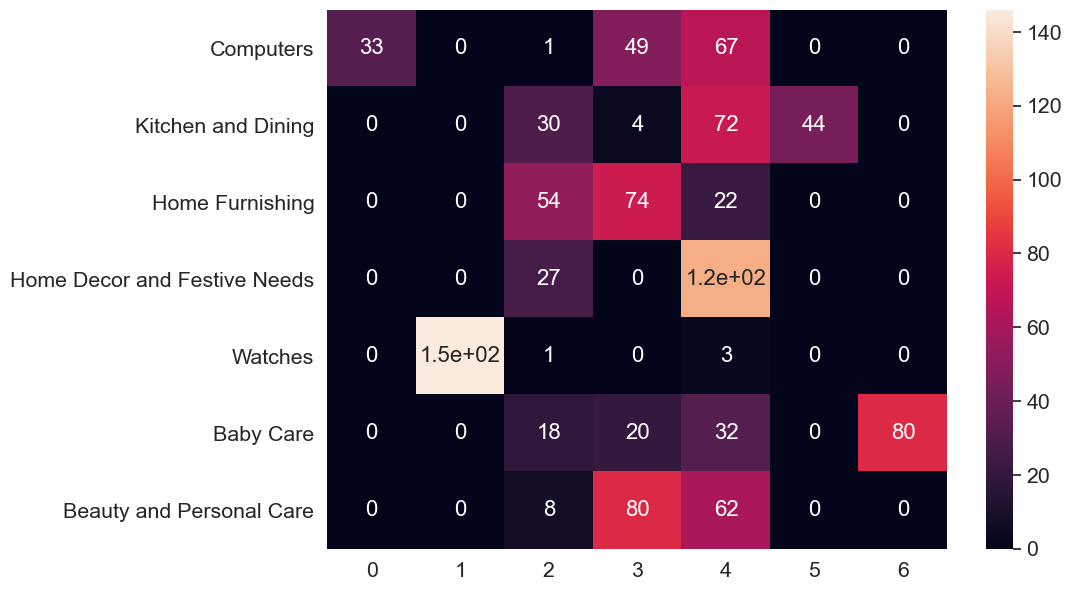

In [252]:
import seaborn as sn

df_cm = pd.DataFrame(array_cm, range(7), range(7))
df_cm = df_cm.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [253]:
df_result['category_KMeans'].value_counts()

4    381
3    227
1    146
2    139
6     80
5     44
0     33
Name: category_KMeans, dtype: int64

## ARI Score

In [254]:
from sklearn.metrics.cluster import adjusted_rand_score


adjusted_rand_score(df_result['category_KMeans'], df_result['Category_Name'])

0.268283928867335

# Another Method for dimensional reduction : UMap 

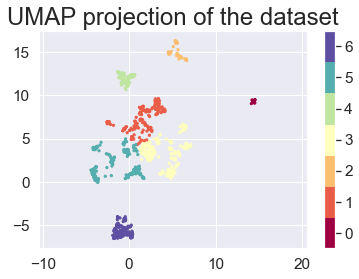

In [210]:
import umap

reducer = umap.UMAP()

reducer.fit(tf_idf_data_smooth)

embedding = reducer.transform(tf_idf_data_smooth)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute

#assert(np.all(embedding == reducer.embedding_))
embedding.shape




df_embedding=pd.DataFrame(embedding)
df_embedding

#df_umap=df1.merge(df_embedding,on=df1.index,how='left')

#df_umap

# KMeans on embedding


X = embedding.copy()
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


# from silhouette_score, best k in n_clusters

kmeans = KMeans(n_clusters=7, random_state=0,init='random').fit(X)


ar = kmeans.predict(X)


df = pd.DataFrame(ar)

df_result_umap = df1.merge(df,on=df1.index,how='left')

df_result_umap.rename(columns={0:'category_KMeans'},inplace=True)


df_result_umap.head(5)

df_result_umap['category_KMeans'].value_counts()



### graphe

from sklearn.datasets import load_digits

digits = load_digits()

plt.scatter(embedding[:, 0], embedding[:, 1], c=df_result_umap['category_KMeans'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('UMAP projection of the dataset', fontsize=24);
plt.show()

In [211]:
embedding.shape

(1050, 2)

## Confusion matrix Umap :

In [62]:
List_Cat = list(df_result_umap['Category'].unique())
List_Cat

from sklearn.metrics import confusion_matrix

Category_Name = []

for i in df_result_umap['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_umap['Category_Name']=Category_Name
    

y_true_umap = df_result_umap['Category_Name']
y_pred_umap = df_result_umap['category_KMeans']
array_cm_umap = confusion_matrix(y_true_umap, y_pred_umap)
array_cm_umap

import seaborn as sn

df_cm_umap = pd.DataFrame(array_cm_umap, range(7), range(7))
df_cm_umap = df_cm_umap.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_umap, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## ARI SCORE

In [65]:
from sklearn.metrics.cluster import adjusted_rand_score


adjusted_rand_score(df_result_umap['category_KMeans'], df_result_umap['Category_Name'])


0.4225813173292274

# Another method : t-sne + K-means

In [75]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

In [201]:
#we re-use the matrix result of truncatedSVD


from sklearn.manifold import TSNE
X = result.copy()
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1050, 2)

In [202]:
df_embedding_tsne=pd.DataFrame(X_embedded)


X = X_embedded.copy()
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


# from silhouette_score, best k in n_clusters

kmeans = KMeans(n_clusters=7, random_state=0,init='random').fit(X)


ar_tsne = kmeans.predict(X)


df_tsne = pd.DataFrame(ar_tsne)

df_result_tsne = df1.merge(df_tsne,on=df1.index,how='left')

df_result_tsne.rename(columns={0:'category_KMeans'},inplace=True)


df_result_tsne.head(5)

,key_0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,category_KMeans
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,0
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""...",Baby Care,0
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",...",Baby Care,0
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value""=>""Flat""}, {""key""=>""Material"", ""value""=>""Cotton""}...",Home Furnishing,1
4,4,6325b6870c54cd47be6ebfbffa6

In [203]:
emb_tsne = pd.DataFrame(X_embedded)
emb_tsne_km = emb_tsne.merge(df_tsne,on=emb_tsne.index,how='left')
emb_tsne_km

emb_tsne_km.drop(['key_0'], axis=1, inplace=True)
emb_tsne_km.rename(columns={'0_x':'x_1'},inplace=True)
emb_tsne_km.rename(columns={1:'x_2'},inplace=True)
emb_tsne_km.rename(columns={'0_y':'y'},inplace=True)

In [204]:
emb_tsne_km

,x_1,x_2,y
0,3.652065,-19.914419,0
1,8.694409,-9.061419,0
2,9.450050,-10.671978,0
3,-11.249797,-27.295347,1
4,-11.207521,-27.679491,1
...,...,...,...
1045,-19.093702,3.102404,5
1046,-18.910652,1.742836,5
1047,2.989295,-1.089206,5
1048,1.032173,0.132952,5


In [205]:
emb_tsne_km['y'].value_counts()

3    219
0    164
1    163
4    151
5    140
6    130
2     83
Name: y, dtype: int64

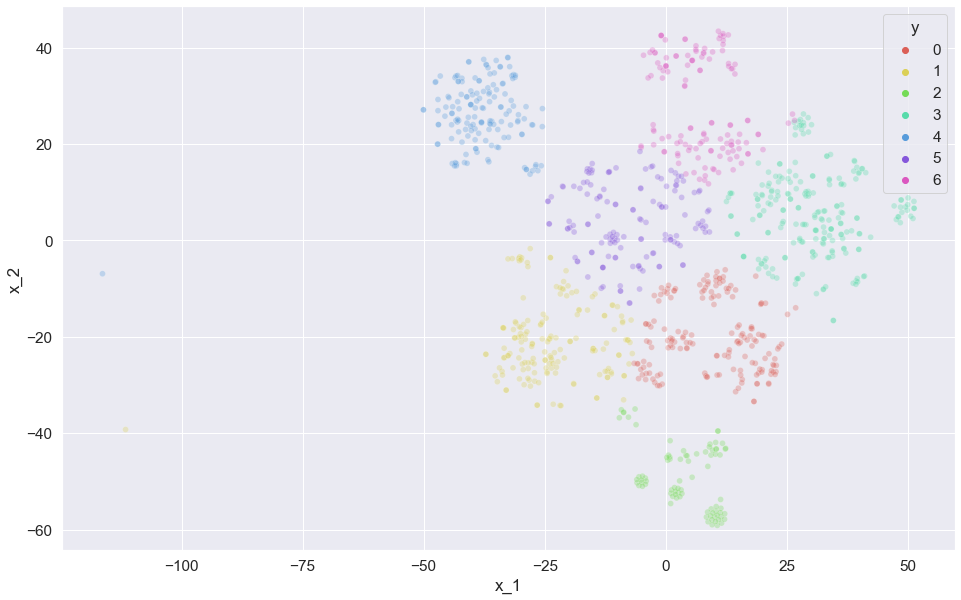

In [206]:
# emb_tsne_km['tsne-2d-one'] = tsne_results[:,1]
# emb_tsne_km['tsne-2d-two'] = tsne_results[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x_1", y='x_2',
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=emb_tsne_km,
    legend="full",
    alpha=0.3
)

plt.show()

## Matrice de confusion t-sne

In [207]:

Category_Name = []

for i in df_result_tsne['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_tsne['Category_Name']=Category_Name
    

y_true_tsne = df_result_tsne['Category_Name']
y_pred_tsne = df_result_tsne['category_KMeans']
array_cm_tsne = confusion_matrix(y_true_tsne, y_pred_tsne)
array_cm_tsne

array([[  0,   0,   0,  72,   1,  33,  44],
       [ 13,  19,  77,  22,   2,   9,   8],
       [130,  19,   0,   0,   0,   1,   0],
       [  2,   6,   4,   3,   1,  56,  78],
       [  0,   1,   0,   0, 147,   2,   0],
       [ 18, 103,   2,  11,   0,  16,   0],
       [  1,  15,   0, 111,   0,  23,   0]], dtype=int64)

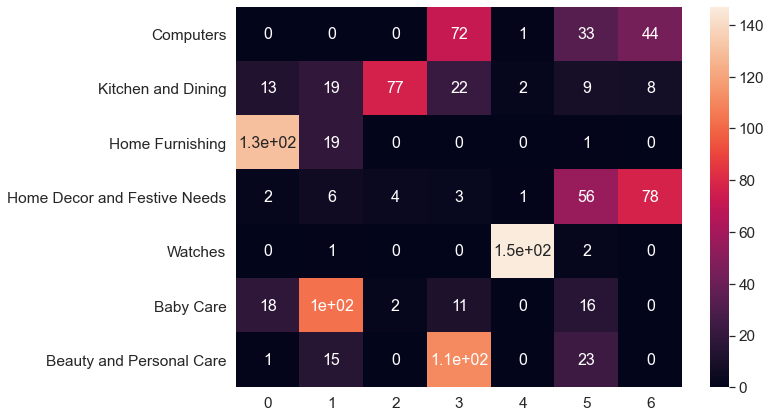

In [208]:
import seaborn as sn

df_cm_tsne = pd.DataFrame(array_cm_tsne, range(7), range(7))
df_cm_tsne = df_cm_tsne.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_tsne, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## ARI SCORE

In [209]:
from sklearn.metrics.cluster import adjusted_rand_score


adjusted_rand_score(df_result_tsne['category_KMeans'], df_result_tsne['Category_Name'])

0.4580735281769484

# ------------------------------------------------------------------------------

# Picture analysis

In [60]:
%matplotlib inline
from os import listdir
import cv2


path = "C:/Users/ykele/Openclassrooms/P6_keles_yalcin_Classifiez_automatiquement_des_biens_de_consommation/Flipkart/Images/"

# path = "C:\\Users\\ykele\\Openclassrooms\\Cours_OpenClassrooms\\Cours_11_Données_Visuelles\\TP_Météo_important\\dataset\\"

list_photos = [file for file in listdir(path)]
print(len(list_photos))



1050


In [61]:

sift = cv2.xfeatures2d.SIFT_create()

image = cv2.imread((path+list_photos[1]),0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram

kp, des = sift.detectAndCompute(image, None)

img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

AttributeError: module 'cv2' has no attribute 'xfeatures2d'

# Pré-processing by SIFT

## Create descriptors for each image
* Grey and equalization
* "sift_keypoints_by_img" used to create histograms for each image

In [17]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\ykele\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           947.87 secondes


## Create descriptors clusters
* use MiniBatchKMeans

In [18]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

# la racine carré du nombre de descripteurs : méthode pour nb de clusters
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :           174.94 secondes


## Create features for images
* Each image : 
   - predict cluster number for each descriptors
   - create a histogram = count how many descriptors are in each cluster

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [19]:
# Creation of histograms (features)
temps1=time.time()


# des : liste des descripteurs par image
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            10.10 secondes


## Dimensional reduction

### PCA

* PCA allows creating uncorrelated features and decrease their dimension, keeping a high level of variance
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE
* Impact is a better separation of datas and quicker treatment through T-SNE

In [20]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


### T-SNE
* 2 composants T-SNE to watch in 2-dimension

In [21]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne_pictures = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
#df_tsne["class"] = data["label_name"]
print(df_tsne_pictures.shape)

(1050, 2)


In [61]:
list_photos

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

In [22]:
df_tsne_pictures

,tsne1,tsne2
0,15.200227,6.381629
1,-7.408085,-24.783886
2,2.602641,24.689255
3,1.624532,-14.513379
4,-23.278316,13.903914
...,...,...
1045,3.233975,-17.069635
1046,11.759078,-13.325962
1047,-5.748380,-19.617489
1048,-5.482061,8.435179


## K-Means


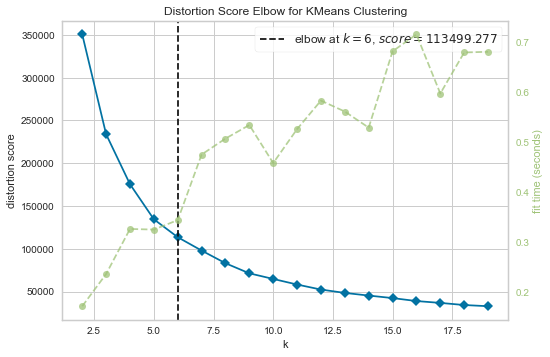

11.240945199999715


In [23]:
from sklearn.cluster import KMeans

data_pca = df_tsne_pictures.copy()        

X = data_pca.values
#std_scale = preprocessing.StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)

# Which k do we have to choose ?

start_time = timeit.default_timer()

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer



# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

elapsed = timeit.default_timer() - start_time

print(elapsed)

## Measure analysis : similarity between categories and clusters

###  Clusters creation from T-SNE

In [25]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X)

df_tsne_pictures["cluster"] = cls.labels_

df_tsne_pictures['image']=list_photos

print(df_tsne_pictures.shape)


(1050, 3)


In [26]:
df_tsne_pictures

,tsne1,tsne2,cluster,image
0,15.200227,6.381629,6,009099b1f6e1e8f893ec29a7023153c4.jpg
1,-7.408085,-24.783886,1,0096e89cc25a8b96fb9808716406fe94.jpg
2,2.602641,24.689255,3,00cbbc837d340fa163d11e169fbdb952.jpg
3,1.624532,-14.513379,1,00d84a518e0550612fcfcba3b02b6255.jpg
4,-23.278316,13.903914,0,00e966a5049a262cfc72e6bbf68b80e7.jpg
...,...,...,...,...
1045,3.233975,-17.069635,1,feefbdff924dd6b7cc266449c9a36d69.jpg
1046,11.759078,-13.325962,4,ff24511994fc459d04145231c8876d6c.jpg
1047,-5.748380,-19.617489,1,ffbf3794aa8cb6bb8d3f313d0a549a09.jpg
1048,-5.482061,8.435179,6,ffc2e1fc7c886ec09a331040ada038aa.jpg


### Display images according to clusters and calculate ARI Score (categories / clusters)
* ARI Score : 

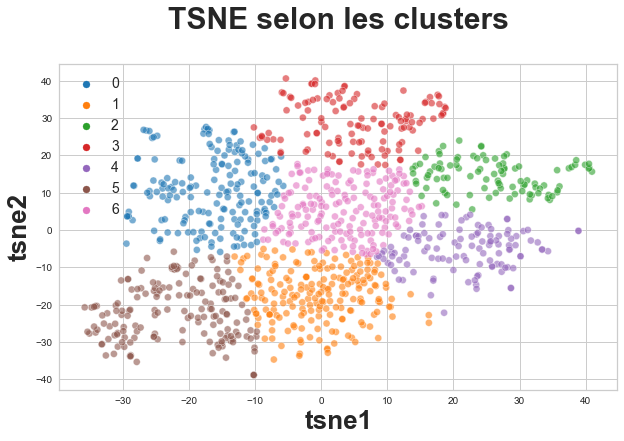

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_pictures,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# data est le nom du dataframe avec les labels, que nous aurons une fois les labels définies grace aux descriptions

# labels = data["label"]
# print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [28]:
df_tsne_pictures['cluster'].value_counts()

1    200
6    176
0    175
5    166
3    121
4    115
2     97
Name: cluster, dtype: int64

In [ ]:
# la différence avec le tp exemple (météo) et que nous définissons les clusters (définis dans l'exemple par les titres des images)
# par les descriptions ici. Il faudra insérer cette notion avant le traitement d'image a priori.

In [27]:
# la matrice de confusion qui arrive ensuite 

In [30]:
df1_copy = df1.sort_values(by=['image'])

df1_copy.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category
280,009099b1f6e1e8f893ec29a7023153c4,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-166-analog-watch-girls-women/p/itmehzpfg7n2r4sf?pid=WATEHZPFAPQKUASQ,"palito PLO 166 Analog Watch - For Girls, Women","[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 166 Analog Watch - For Girls, Women""]",WATEHZPFAPQKUASQ,1500.0,199.0,009099b1f6e1e8f893ec29a7023153c4.jpg,False,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code PLO 166 Ideal For Girls, Women Occasion Party-Wedding Warranty 6 months Body Features Dial Shape Ro...",No rating available,No rating available,palito,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Analog""}, {""key""=>""Style Code"", ""value""=>""PLO 166""}, {""key""=>""Ideal For"", ""value""=>""Girls, Women""}, {""key""=>""Occasion"", ""value""=>""Party-Wedding...",Watches
86,0096e89cc25a8b96fb9808716406fe94,2016-06-17 14:13:36 +0000,http://www.flipkart.com/oxford-tawa-15-cm-diameter/p/itmejqr9e5a58yvz?pid=PTPEJQR9VKFUV4HY,oxford Tawa 15 cm cm diameter,"[""Kitchen & Dining >> Cookware >> Pots & Pans >> Pans & Tawas >> oxford Pans & Tawas >> oxford Tawa 15 cm cm diameter (Aluminium, Non-st...""]",PTPEJQR9VKFUV4HY,699.0,659.0,0096e89cc25a8b96fb9808716406fe94.jpg,False,"Key Features of oxford Tawa 15 cm cm diameter Non-stick Tawa,Specifications of oxford Tawa 15 cm cm diameter (Aluminium, Non-stick) General Pan Type Flat Non-stick Yes Brand oxford Model Number 16...",No rating available,No rating available,oxford,"{""product_specification""=>[{""key""=>""Pan Type"", ""value""=>""Flat""}, {""key""=>""Non-stick"", ""value""=>""Yes""}, {""key""=>""Brand"", ""value""=>""oxford""}, {""key""=>""Model Number"", ""value""=>""16""}, {""key""=>""Inducti...",Kitchen and Dining
724,00cbbc837d340fa163d11e169fbdb952,2016-01-01 19:37:22 +0000,http://www.flipkart.com/flazee-home-trends-beige-144-78-cm-table-runner/p/itme8gr3d6tdghqa?pid=TBRE8GR3RSTQTXMJ,Flazee Home Trends Beige 144.78 cm Table Runner,"[""Home Furnishing >> Kitchen & Dining Linen >> Table Runners""]",TBRE8GR3RSTQTXMJ,1299.0,399.0,00cbbc837d340fa163d11e169fbdb952.jpg,False,Buy Flazee Home Trends Beige 144.78 cm Table Runner at Rs. 399 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!,No rating available,No rating available,Flazee Home Trends,"{""product_specification""=>[{""key""=>""Shape"", ""value""=>""Rectangle""}, {""key""=>""Brand"", ""value""=>""Flazee Home Trends""}, {""key""=>""Reversible"", ""value""=>""Yes""}, {""key""=>""Design Code"", ""value""=>""TBLRUN04...",Home Furnishing


In [32]:

df_result_pictures = df1.merge(df_tsne_pictures,on='image',how='left')

df_result_pictures.rename(columns={0:'category_KMeans'},inplace=True)


df_result_pictures.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,tsne1,tsne2,cluster
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,-3.593026,17.679399,6
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""...",Baby Care,12.489269,12.467669,6
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",...",Baby Care,-22.078867,12.846642,0


In [35]:
df_tsne_pictures[df_tsne_pictures['image']=='64d5d4a258243731dc7bbb1eef49ad74.jpg']

,tsne1,tsne2,cluster,image
404,-22.078867,12.846642,0,64d5d4a258243731dc7bbb1eef49ad74.jpg


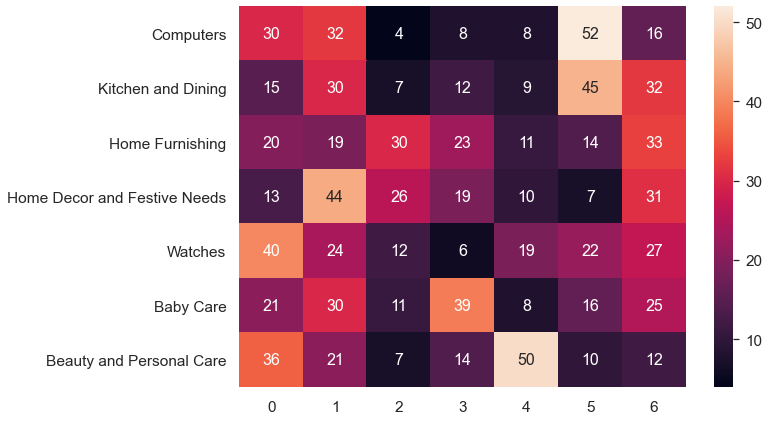

In [36]:
from sklearn.metrics import confusion_matrix


Category_Name = []

for i in df_result_pictures['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_pictures['Category_Name']=Category_Name
    

y_true_pict = df_result_pictures['Category_Name']
y_pred_pict = df_result_pictures['cluster']
array_cm_pict = confusion_matrix(y_true_pict, y_pred_pict)
array_cm_pict

import seaborn as sn

df_cm_pict = pd.DataFrame(array_cm_pict, range(7), range(7))
df_cm_pict = df_cm_pict.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_pict, annot=True, annot_kws={"size": 16}) # font size

plt.show()

### ARI SCORE

In [37]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_result_pictures['cluster'], df_result_pictures['Category'])

0.039054969359311305

# Another method : VGG16 - Transfert learning

# VGG16 : 

In [14]:
flipkart_path = 'C:/Users/ykele/Openclassrooms/P6_keles_yalcin_Classifiez_automatiquement_des_biens_de_consommation/Flipkart/Images/'

In [15]:
# on freeze les couches
# on garde la structure du VGG16
# on ajoute une couche flatten pour obtenir la bonne dimension de matrice
# on ajoute une couche dense pour une première réduction de dimension

In [16]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import keras

model = tf.keras.Sequential()

vgg16 = VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3)) # Création du modèle VGG-16 implementé par Keras sans la dernière couche

model.add(vgg16)
#model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(4096))
#model.add(tf.keras.layers.Dense(1024))

model.add(tf.keras.layers.Dense(512))



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


for layer in model.layers:
    layer.trainable = False

model.build((None,224,224,3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
Total params: 27,560,256
Trainable params: 0
Non-trainable params: 27,560,256
_________________________________________________________________


In [17]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

In [118]:


img = load_img(flipkart_path + '0d3e1dc0d38be59e9927e47f152e48aa.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

y = model.predict(img)  

In [ ]:
# cas général :

In [18]:
liste_1 = []

for i in df1['image'] :

    img = load_img(flipkart_path + i, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut vgg16

    y = model.predict(img)  
    
    liste_1.append(y)

C:\Users\ykele\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [19]:
df_i = pd.DataFrame(liste_1[0])

for i in range(1,len(df1['image'])):
    df = pd.DataFrame(liste_1[i])
    df_i = df_i.append(df)



df_i = df_i.reset_index(drop=True)

## ACP (VGG16)

In [20]:
pca = decomposition.PCA(n_components=200)
feat_pca= pca.fit_transform(df_i)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset après réduction PCA :  (1050, 200)


In [21]:
feat_pca

array([[-44.333935  , -56.461407  , -20.801704  , ...,  -1.9590306 ,
         18.255644  , -10.841915  ],
       [-25.39069   , -62.818226  , -32.107018  , ...,   3.7770712 ,
          5.400107  ,   9.205001  ],
       [-33.73657   , -49.69635   , -20.727753  , ..., -16.925095  ,
         -5.2465916 ,  15.788568  ],
       ...,
       [-59.672215  , -64.86299   ,   0.46579972, ...,  11.2167845 ,
         13.317203  , -13.17062   ],
       [ -4.29119   , -43.640636  , -10.156958  , ...,  -2.39007   ,
        -13.629978  ,  -5.283911  ],
       [-56.803303  , -21.352003  ,  -4.4842978 , ...,   4.3956256 ,
          3.3740125 ,  17.072193  ]], dtype=float32)

In [22]:
# Eboulis des valeurs propres
display_scree_plot(pca)

NameError: name 'display_scree_plot' is not defined

In [ ]:
# on peut prendre n_comp = 500

## t-sne (VGG16)

In [23]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_i = tsne.fit_transform(feat_pca)

df_tsne_i = pd.DataFrame(X_tsne_i[:,0:2], columns=['tsne1', 'tsne2'])
#df_tsne["class"] = data["label_name"]
print(df_tsne_i.shape)

(1050, 2)


In [24]:
df_tsne_i

,tsne1,tsne2
0,23.905050,-18.593775
1,13.963545,16.516506
2,21.013838,1.224178
3,29.956102,-0.821881
4,28.810158,0.588967
...,...,...
1045,16.766380,-15.217710
1046,6.554708,25.421070
1047,8.487938,-0.330305
1048,6.427771,25.074287


In [25]:
from sklearn import cluster, metrics

X_i = df_tsne_i.values

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_i)

df_tsne_i["cluster"] = cls.labels_
print(df_tsne_i.shape)

#df_tsne_pictures['image']=list_photos


(1050, 3)


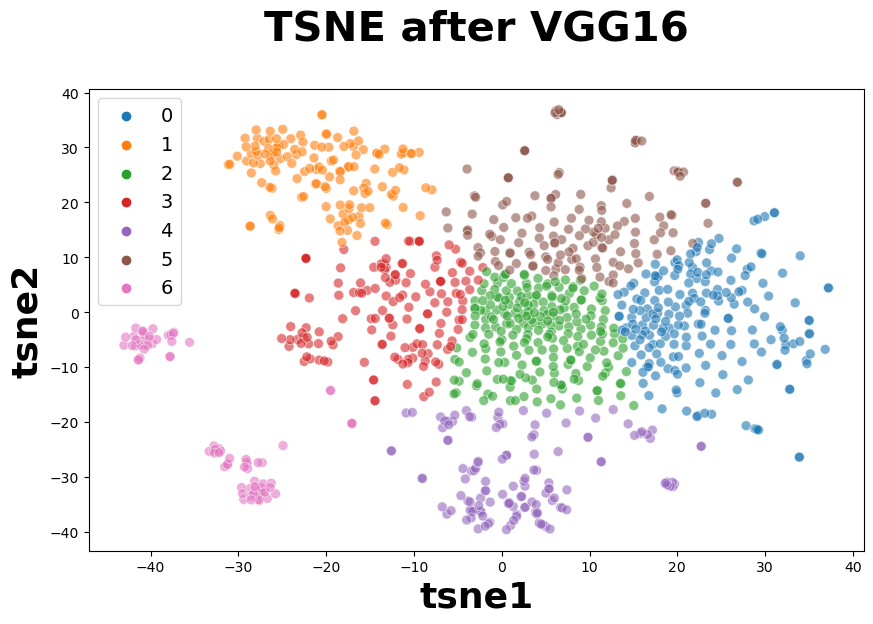

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_i,
    legend="brief")

plt.title('TSNE after VGG16', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# data est le nom du dataframe avec les labels, que nous aurons une fois les labels définies grace aux descriptions

# labels = data["label"]
# print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [27]:

df_result_i = df1.merge(df_tsne_i,on=df1.index,how='left')

df_result_i.rename(columns={0:'category_KMeans'},inplace=True)


df_result_i.head(10)

,key_0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,tsne1,tsne2,cluster
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,23.905050,-18.593775,0
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""...",Baby Care,13.963545,16.516506,5
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",...",Baby Care,21.013838,1.224178,0
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value""=>""Flat""}, {""key""=>""Material"", ""value""=>"

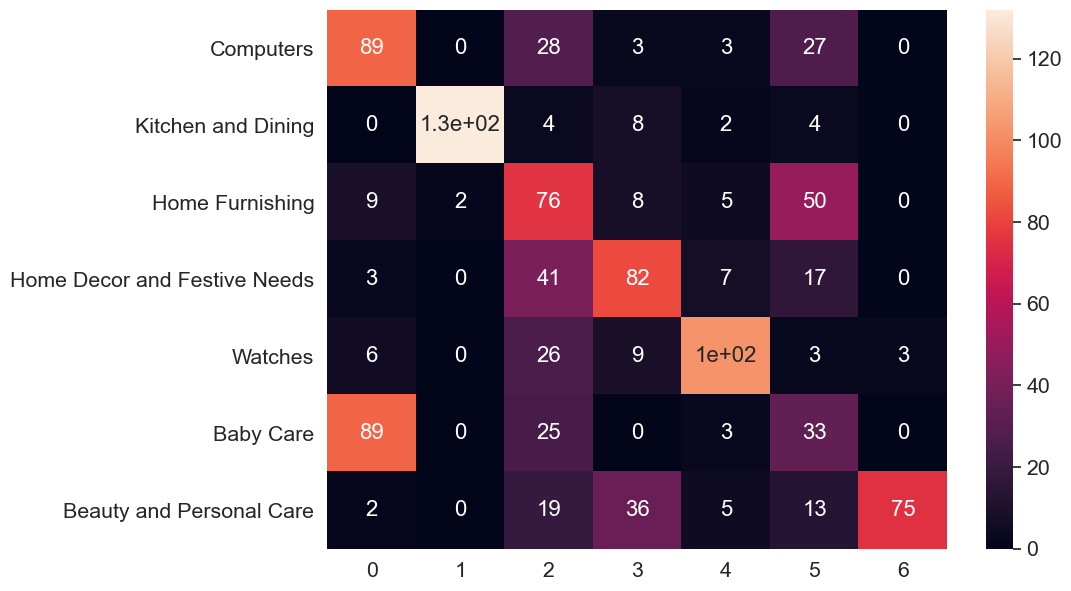

In [33]:
from sklearn.metrics import confusion_matrix


Category_Name = []

for i in df_result_i['Category'] :
    if i == 'Computers':
        val = 3
    if i == 'Kitchen and Dining':
        val = 6    
    if i == 'Home Furnishing':
        val = 5 
    if i == 'Home Decor and Festive Needs':
        val = 2  
    if i == 'Watches':
        val = 1         
    if i == 'Baby Care':
        val = 0  
    if i == 'Beauty and Personal Care':
        val = 4
    
    Category_Name.append(val)

df_result_i['Category_Name']=Category_Name
    

y_true_i = df_result_i['Category_Name']
y_pred_i = df_result_i['cluster']
array_cm_i = confusion_matrix(y_true_i, y_pred_i)
array_cm_i

import seaborn as sn

df_cm_i = pd.DataFrame(array_cm_i, range(7), range(7))
df_cm_i = df_cm_i.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_i, annot=True, annot_kws={"size": 16}) # font size

plt.show()

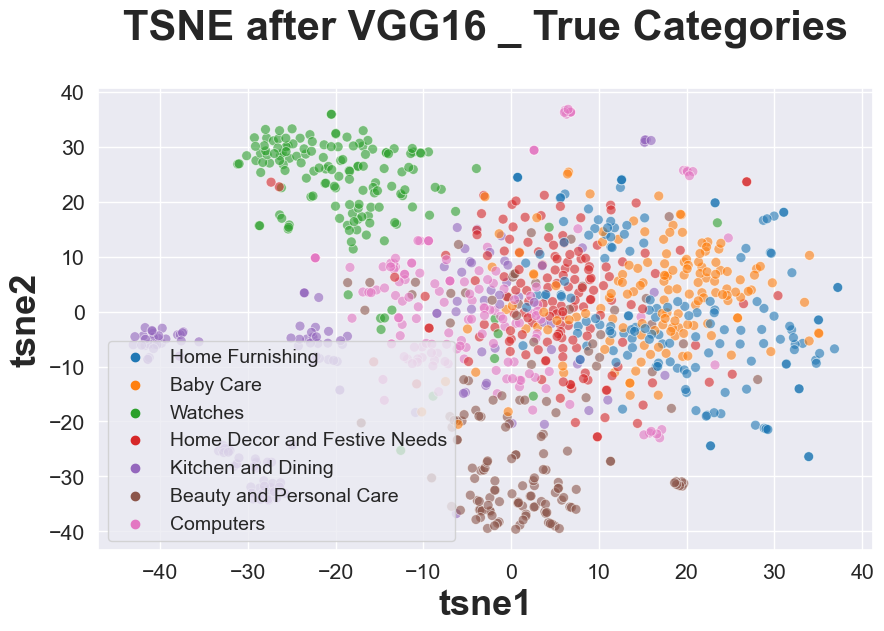

In [34]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="Category",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_result_i,
    legend="brief")

plt.title('TSNE after VGG16 _ True Categories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# data est le nom du dataframe avec les labels, que nous aurons une fois les labels définies grace aux descriptions

# labels = data["label"]
# print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [35]:
## ARI score

In [36]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_result_i['cluster'], df_result_i['Category'])

0.3427358762651205

In [37]:
df_result_i['cluster'].value_counts()

2    219
0    198
5    147
3    146
1    134
4    128
6     78
Name: cluster, dtype: int64

## UMAP (VGG16) :

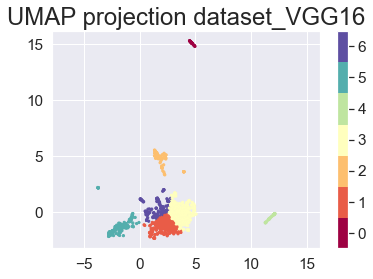

In [261]:
import umap
from sklearn.cluster import KMeans


reducer = umap.UMAP()

reducer.fit(df_i.values)

embedding_i = reducer.transform(df_i.values)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute

#assert(np.all(embedding == reducer.embedding_))
embedding_i.shape




df_embedding_i=pd.DataFrame(embedding_i)
df_embedding_i



# KMeans on embedding


X_i = embedding_i.copy()
#std_scale = preprocessing.StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)


# from silhouette_score, best k in n_clusters

kmeans = KMeans(n_clusters=7, random_state=0,init='random').fit(X_i)


ar_i = kmeans.predict(X_i)


df_i_i = pd.DataFrame(ar_i)

df_result_umap_i = df1.merge(df_i_i,on=df1.index,how='left')

df_result_umap_i.rename(columns={0:'category_KMeans'},inplace=True)


df_result_umap_i.head(5)

df_result_umap_i['category_KMeans'].value_counts()



### graphe

from sklearn.datasets import load_digits

digits = load_digits()

plt.scatter(embedding_i[:, 0], embedding_i[:, 1], c=df_result_umap_i['category_KMeans'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('UMAP projection dataset_VGG16', fontsize=24);
plt.show()

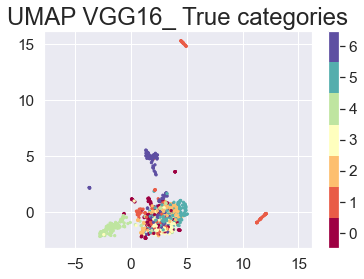

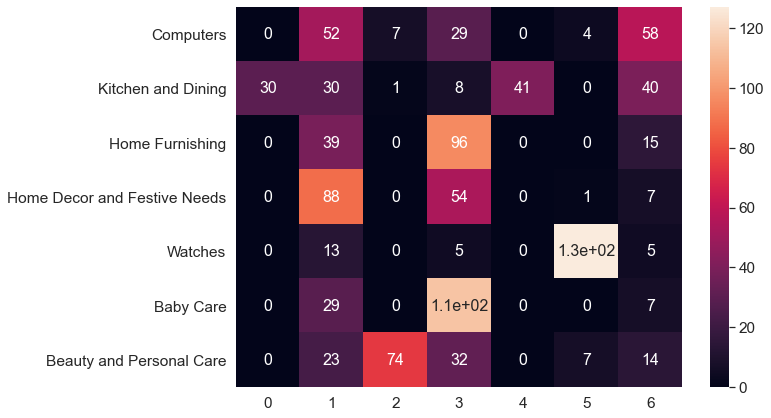

In [262]:
List_Cat = list(df_result_umap_i['Category'].unique())
List_Cat

from sklearn.metrics import confusion_matrix

Category_Name = []

for i in df_result_umap_i['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_umap_i['Category_Name']=Category_Name
    

y_true_umap_i = df_result_umap_i['Category_Name']
y_pred_umap_i = df_result_umap_i['category_KMeans']
array_cm_umap_i = confusion_matrix(y_true_umap_i, y_pred_umap_i)
array_cm_umap_i

import seaborn as sn

df_cm_umap_i = pd.DataFrame(array_cm_umap_i, range(7), range(7))
df_cm_umap_i = df_cm_umap_i.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_umap_i, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()

plt.scatter(embedding_i[:, 0], embedding_i[:, 1], c=df_result_umap_i['Category_Name'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('UMAP VGG16_ True categories', fontsize=24);
plt.show()

In [255]:
## ARI score :

In [264]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_result_umap_i['category_KMeans'], df_result_umap_i['Category'])

0.22272411146598758

In [98]:
df_result_umap_i['category_KMeans'].value_counts()

3    367
0    261
4    138
1    130
6     82
5     41
2     31
Name: category_KMeans, dtype: int64

# new model : RESNET50

In [1]:
# https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

In [266]:
# même démarche que pour VGG16

In [224]:
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input, decode_predictions
import numpy as np

model_resnet50 = tf.keras.Sequential()

resnet50 = ResNet50(include_top=False,weights="imagenet",input_shape=(224, 224, 3))

model_resnet50.add(resnet50)
model_resnet50.add(tf.keras.layers.Flatten())
model_resnet50.add(tf.keras.layers.Dense(512))


model_resnet50.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


for layer in model_resnet50.layers:
    layer.trainable = False

model_resnet50.build((None,224,224,3))

model_resnet50.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_5 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
Total params: 74,968,448
Trainable params: 0
Non-trainable params: 74,968,448
_________________________________________________________________


In [100]:
img_path = flipkart_path + '0d3e1dc0d38be59e9927e47f152e48aa.jpg' 
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

img.show()

preds = model.predict(x)


In [62]:
# cas général :

In [225]:
liste_2 = []

for i in df1['image'] :

    img = load_img(flipkart_path + i, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut ResNet50

    y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
    
    liste_2.append(y)

C:\Users\ykele\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [226]:
liste_2[0].shape

(1, 512)

In [227]:
df_j = pd.DataFrame(liste_2[0])

for i in range(1,len(df1['image'])):
    df = pd.DataFrame(liste_2[i])
    df_j = df_j.append(df)



df_j = df_j.reset_index(drop=True)

### ACP : 

In [240]:
pca = decomposition.PCA(n_components=200)
feat_pca2= pca.fit_transform(df_j)
print("Dimensions dataset après réduction PCA : ", feat_pca2.shape)

Dimensions dataset après réduction PCA :  (1050, 200)


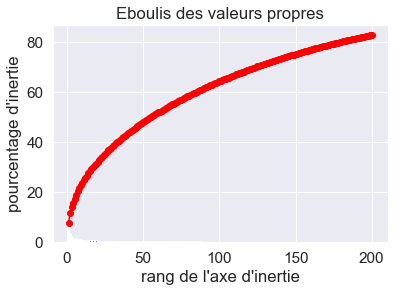

In [241]:
# Eboulis des valeurs propres
display_scree_plot(pca)

In [242]:
### on prendra n=200 pour avoir plus de 80% de la variance expliquée

#### t-sne

In [243]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_j = tsne.fit_transform(feat_pca2)

df_tsne_j = pd.DataFrame(X_tsne_j[:,0:2], columns=['tsne1', 'tsne2'])
#df_tsne["class"] = data["label_name"]
print(df_tsne_j.shape)

(1050, 2)


In [244]:
df_tsne_j

,tsne1,tsne2
0,14.041649,-18.132236
1,-0.511545,17.774786
2,14.872446,-7.384116
3,12.607465,10.290195
4,23.533625,-3.378334
...,...,...
1045,22.836226,-14.209800
1046,4.364942,-5.092019
1047,1.249043,-19.626221
1048,2.060809,-2.939120


### K-Means

In [245]:
from sklearn import cluster, metrics

X_j = df_tsne_j.values

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_j)

df_tsne_j["cluster"] = cls.labels_
print(df_tsne_j.shape)

#df_tsne_pictures['image']=list_photos


(1050, 3)


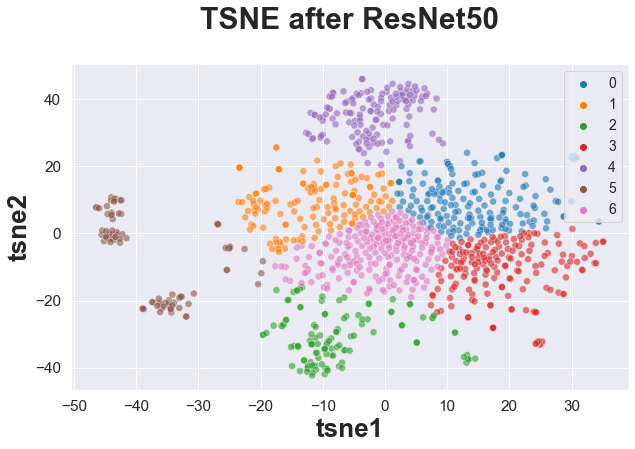

In [246]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_j,
    legend="brief")

plt.title('TSNE after ResNet50', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# data est le nom du dataframe avec les labels, que nous aurons une fois les labels définies grace aux descriptions

# labels = data["label"]
# print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [247]:

df_result_j = df1.merge(df_tsne_j,on=df1.index,how='left')

df_result_j.rename(columns={0:'category_KMeans'},inplace=True)


df_result_j.head(3)

,key_0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category,tsne1,tsne2,cluster
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester D...",Home Furnishing,14.041649,-18.132236,3
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""...",Baby Care,-0.511545,17.774786,1
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""}, {""key""=>""GSM"", ""value""=>""360""}, {""key""=>""Type"",...",Baby Care,14.872446,-7.384116,3


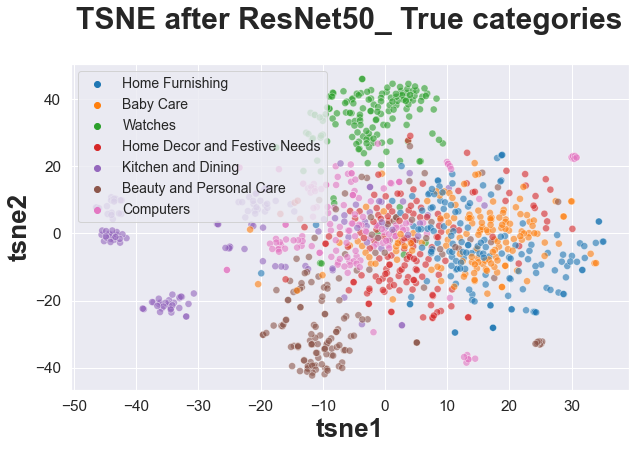

In [248]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="Category",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_result_j,
    legend="brief")

plt.title('TSNE after ResNet50_ True categories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# data est le nom du dataframe avec les labels, que nous aurons une fois les labels définies grace aux descriptions

# labels = data["label"]
# print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

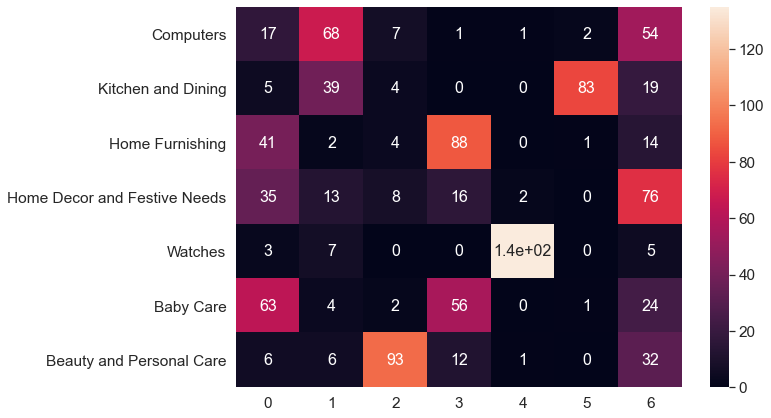

In [249]:
from sklearn.metrics import confusion_matrix


Category_Name = []

for i in df_result_j['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_j['Category_Name']=Category_Name
    

y_true_j = df_result_j['Category_Name']
y_pred_j = df_result_j['cluster']
array_cm_j = confusion_matrix(y_true_j, y_pred_j)
array_cm_j

import seaborn as sn

df_cm_j = pd.DataFrame(array_cm_j, range(7), range(7))
df_cm_j = df_cm_j.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_j, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [250]:
### ARI Score :

In [251]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_result_j['cluster'], df_result_j['Category'])

0.323759204528688

## Umap (ResNet50)

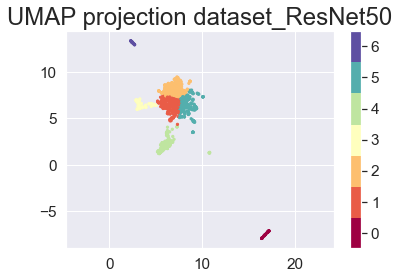

In [218]:
import umap

reducer = umap.UMAP()

reducer.fit(df_j.values)

embedding_j = reducer.transform(df_j.values)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute

#assert(np.all(embedding == reducer.embedding_))
embedding_j.shape




df_embedding_j=pd.DataFrame(embedding_j)
df_embedding_j



# KMeans on embedding


X_j = embedding_j.copy()
#std_scale = preprocessing.StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)


# from silhouette_score, best k in n_clusters

kmeans = KMeans(n_clusters=7, random_state=0,init='random').fit(X_j)


ar_j = kmeans.predict(X_j)


df_j_j = pd.DataFrame(ar_j)

df_result_umap_j = df1.merge(df_j_j,on=df1.index,how='left')

df_result_umap_j.rename(columns={0:'category_KMeans'},inplace=True)


df_result_umap_j.head(5)

df_result_umap_j['category_KMeans'].value_counts()



### graphe

from sklearn.datasets import load_digits

digits = load_digits()

plt.scatter(embedding_j[:, 0], embedding_j[:, 1], c=df_result_umap_j['category_KMeans'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('UMAP projection dataset_ResNet50', fontsize=24);
plt.show()

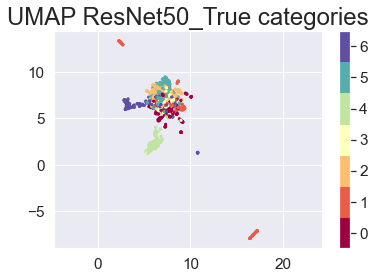

In [221]:
from sklearn.datasets import load_digits

digits = load_digits()

plt.scatter(embedding_j[:, 0], embedding_j[:, 1], c=df_result_umap_j['Category_Name'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('UMAP ResNet50_True categories', fontsize=24);
plt.show()

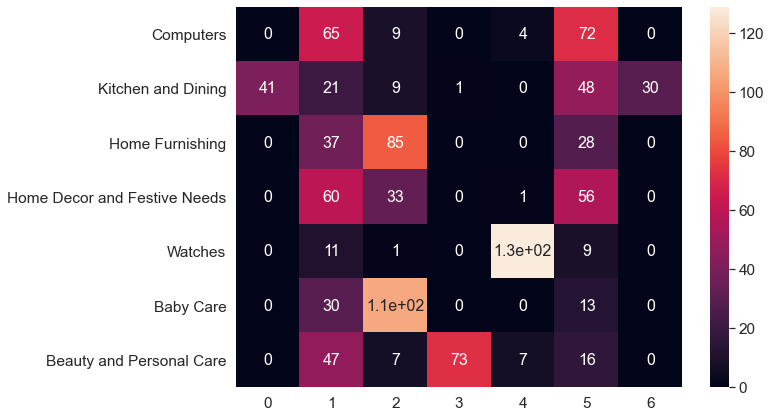

In [220]:
List_Cat = list(df_result_umap_j['Category'].unique())
List_Cat

from sklearn.metrics import confusion_matrix

Category_Name = []

for i in df_result_umap_j['Category'] :
    if i == 'Computers':
        val = 0
    if i == 'Kitchen and Dining':
        val = 1    
    if i == 'Home Furnishing':
        val = 2  
    if i == 'Home Decor and Festive Needs':
        val = 3  
    if i == 'Watches':
        val = 4         
    if i == 'Baby Care':
        val = 5  
    if i == 'Beauty and Personal Care':
        val = 6
    
    Category_Name.append(val)

df_result_umap_j['Category_Name']=Category_Name
    

y_true_umap_j = df_result_umap_j['Category_Name']
y_pred_umap_j = df_result_umap_j['category_KMeans']
array_cm_umap_j = confusion_matrix(y_true_umap_j, y_pred_umap_j)
array_cm_umap_j

import seaborn as sn

df_cm_umap_j = pd.DataFrame(array_cm_umap_j, range(7), range(7))
df_cm_umap_j = df_cm_umap_j.rename(index={0:'Computers',1:'Kitchen and Dining',2:'Home Furnishing',3:'Home Decor and Festive Needs',4:'Watches',
                     5:'Baby Care',6:'Beauty and Personal Care'})
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_umap_j, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [222]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_result_umap_j['category_KMeans'], df_result_umap_j['Category'])

0.23344874605831678

# Supervised :

In [14]:
from tensorflow import keras
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD                # --> cannot. See : https://keras.io/api/optimizers/sgd/
from keras.callbacks import EarlyStopping,ModelCheckpoint
#from google.colab.patches import cv2_imshow          # cannot
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import matplotlib.image as img
from tensorflow import keras
# raccourci vers la classe ImageDataGenerator 
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
from os import listdir


In [15]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [16]:
path_dataset = 'C:/Users/ykele/Openclassrooms/P6_keles_yalcin_Classifiez_automatiquement_des_biens_de_consommation/Flipkart_2/Images/'


In [26]:
# class datasets per class on the computer (by folders)

import shutil

for i in range(df1.shape[0]):

    if df1['Category'][i] == "Beauty and Personal Care" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "BeautyAndPersonalCare")
    elif df1['Category'][i] == "Watches" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "Watches")
    elif df1['Category'][i] == "Home Decor and Festive Needs" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "HomeDecorAndFestiveNeeds")
    elif df1['Category'][i] == "Baby Care" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "BabyCare")
    elif df1['Category'][i] == "Computers" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "Computers")
    elif df1['Category'][i] == "Home Furnishing" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "HomeFurnishing")
    elif df1['Category'][i] == "Kitchen and Dining" :
        shutil.move(path_dataset + df1['image'][i], path_dataset + "KitchenandDining")



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30


#split en dataset d'entraînement et de validation


def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        path_dataset,
        target_size = (height, width), 
        classes = ("BeautyAndPersonalCare","Watches","HomeDecorAndFestiveNeeds","BabyCare","Computers","HomeFurnishing","KitchenandDining"),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        path_dataset,
        target_size = (height, width), 
        classes = ("BeautyAndPersonalCare","Watches","HomeDecorAndFestiveNeeds","BabyCare","Computers","HomeFurnishing","KitchenandDining"),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset
    

In [18]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

## ResNet50 (supervised)

In [20]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 945 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


In [34]:
# on freeze toutes les couches sauf les 4 dernières que l'on va ré-entraîner


conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(7, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [35]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,          
)

C:\Users\ykele\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5


C:\Users\ykele\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


32/32 [==============================] - 44s 808ms/step - loss: 0.4676 - acc: 0.6614 - val_loss: 0.1795 - val_acc: 0.8190
Epoch 2/5
32/32 [==============================] - 25s 713ms/step - loss: 0.0906 - acc: 0.9259 - val_loss: 0.1586 - val_acc: 0.8476
Epoch 3/5
32/32 [==============================] - 24s 638ms/step - loss: 0.0297 - acc: 0.9831 - val_loss: 0.1656 - val_acc: 0.8571
Epoch 4/5
32/32 [==============================] - 25s 676ms/step - loss: 0.0133 - acc: 0.9905 - val_loss: 0.1440 - val_acc: 0.8571
Epoch 5/5
32/32 [==============================] - 25s 653ms/step - loss: 0.0090 - acc: 0.9958 - val_loss: 0.1549 - val_acc: 0.8571


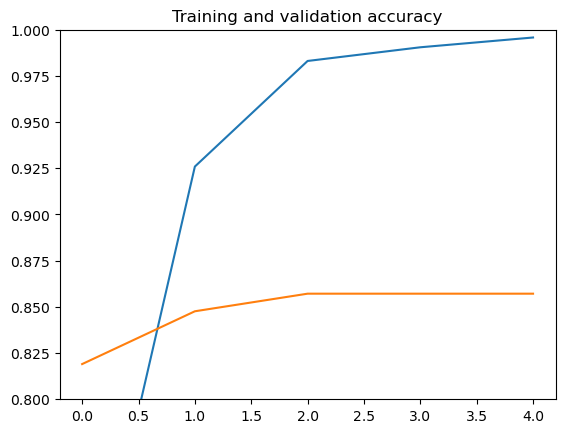

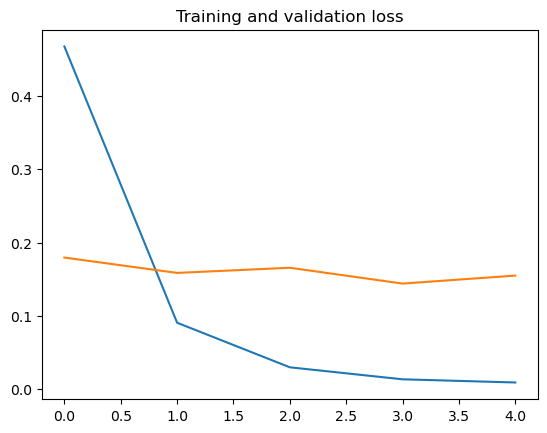

In [37]:
plot_history(history, yrange=(0.8,1))

### save the model

In [38]:
full_model.save_weights('resnet50_P6.h5')

#### To read them again, we create a new model, identical to the one we have trained:

In [21]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(7, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

#### Load : 

In [22]:
full_model.load_weights('resnet50_P6.h5')

## Model Evaluation

[[6.9714824e-11 3.3603701e-08 5.5381633e-10 3.2221441e-09 3.0356024e-09
  2.0170072e-14 1.0000000e+00]]


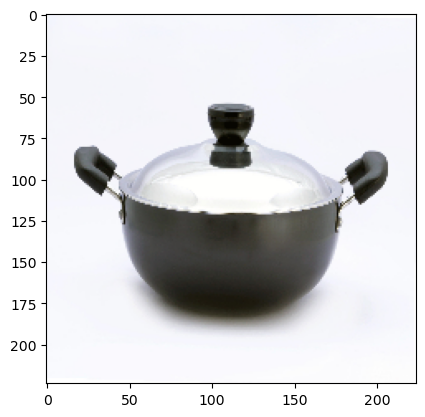

In [43]:
#an example :
# rappel : classes = ("BeautyAndPersonalCare","Watches","HomeDecorAndFestiveNeeds","BabyCare","Computers","HomeFurnishing","KitchenandDining")

from keras.preprocessing import image
from keras.applications.resnet import preprocess_input

img_path = path_dataset+'KitchenandDining/2e8df36b35d22cf219cf8bae6c2af752.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
plt.imshow(img)
plt.show()

In [23]:
# evaluating the model for all images in the training dataset:

import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,7))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

train_labels, train_preds = true_and_predicted_labels(train_dataset)

C:\Users\ykele\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [24]:
train_preds

array([[5.77936021e-07, 3.69967322e-14, 5.08964115e-09, ...,
        9.74341007e-12, 9.99999285e-01, 1.41770720e-10],
       [9.99926686e-01, 2.01759608e-16, 2.22923927e-06, ...,
        7.77980069e-10, 7.56779084e-09, 1.44071566e-06],
       [7.67858666e-10, 1.21087238e-08, 4.99784846e-06, ...,
        9.99994159e-01, 5.57536683e-09, 8.03285043e-12],
       ...,
       [1.10348758e-07, 5.50458422e-14, 2.91220719e-08, ...,
        6.64463983e-07, 4.44127114e-12, 9.99999046e-01],
       [1.50005944e-05, 5.02814283e-11, 8.28972679e-06, ...,
        1.56609531e-10, 2.41633103e-07, 2.45303617e-08],
       [1.42838674e-09, 4.60582995e-11, 3.32748190e-10, ...,
        1.00000000e+00, 2.18289232e-12, 1.30014839e-14]])

In [27]:
# compute accuracy :
# rappel : classes = ("BeautyAndPersonalCare","Watches","HomeDecorAndFestiveNeeds","BabyCare","Computers","HomeFurnishing","KitchenandDining")

threshold = 0.5

def predicted_labels(preds, threshold):
    '''Turn predictions (floats in the last two dimensions) 
    into labels (0 or 1).'''
    pred_labels = np.zeros_like(preds)
    
    # "BeautyAndPersonalCare"
    pred_labels[:,0] = preds[:,0]>=threshold
    # "Watches"
    pred_labels[:,1] = preds[:,1]>=threshold
    # "HomeDecorAndFestiveNeeds"
    pred_labels[:,2] = preds[:,2]>=threshold
    # "BabyCare"
    pred_labels[:,3] = preds[:,3]>=threshold
    # "Computers"
    pred_labels[:,4] = preds[:,4]>=threshold
    # "HomeFurnishing"
    pred_labels[:,5] = preds[:,5]>=threshold
    # "KitchenandDining"
    pred_labels[:,6] = preds[:,6]>=threshold
    
    return pred_labels

train_pred_labels = predicted_labels(train_preds, threshold)
print('predicted labels:')
print(train_pred_labels)
print('true labels:')
print(train_labels)

predicted labels:
[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
true labels:
[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [125]:
list_index_BeautyAndPersonalCare=[]
list_index_Watches=[]
list_index_HomeDecorAndFestiveNeeds=[]
list_index_BabyCare=[]
list_index_Computers=[]
list_index_HomeFurnishing=[]
list_index_KitchenandDining=[]


def misclassified(labels, pred_labels, print_report=True):
    def report(categ, n_misclassified, n_examples): 
        print('{:<4} {:>3} misclassified samples ({:4.2f}%)'.format(
            categ,
            n_misclassified, 
            100*(1-float(n_misclassified)/n_examples))
        )
        
    # total number of examples
    n_examples = len(labels)
    # total number of "BeautyAndPersonalCare"
    n_BeautyAndPersonalCare = sum(labels[:,0])
    # total number of "Watches"
    n_Watches = sum(labels[:,1])
    # total number of HomeDecorAndFestiveNeeds"
    n_HomeDecorAndFestiveNeeds = sum(labels[:,2])
    # total number of "BabyCare"
    n_BabyCare = sum(labels[:,3])
    # total number of "Computers"
    n_Computers = sum(labels[:,4])
    # total number of "HomeFurnishing"
    n_HomeFurnishing = sum(labels[:,5])
    # total number of "KitchenandDining"
    n_KitchenandDining = sum(labels[:,6])    

    # boolean mask for misidentified "BeautyAndPersonalCare"   
    mask_BeautyAndPersonalCare = np.logical_and(pred_labels[:,0] != labels[:,0],labels[:,0]>0.5)
    
    
    # boolean mask for misidentified "Watches"    
    mask_Watches = np.logical_and(pred_labels[:,1] != labels[:,1],labels[:,1]>0.5)
    # boolean mask for misidentified HomeDecorAndFestiveNeeds"   
    mask_HomeDecorAndFestiveNeeds = np.logical_and(pred_labels[:,2] != labels[:,2],labels[:,2]>0.5)
    # boolean mask for misidentified "BabyCare"    
    mask_BabyCare = np.logical_and(pred_labels[:,3] != labels[:,3],labels[:,3]>0.5)
    # boolean mask for misidentified "Computers"    
    mask_Computers = np.logical_and(pred_labels[:,4] != labels[:,4],labels[:,4]>0.5)
    # boolean mask for misidentified "HomeFurnishing"    
    mask_HomeFurnishing = np.logical_and(pred_labels[:,5] != labels[:,5],labels[:,5]>0.5)
    # boolean mask for misidentified "KitchenandDining"    
    mask_KitchenandDining = np.logical_and(pred_labels[:,6] != labels[:,6],labels[:,6]>0.5) 
    

    if print_report:
        #report('All', sum(mask_all), n_examples)
        report('BeautyAndPersonalCare', sum(mask_BeautyAndPersonalCare), n_BeautyAndPersonalCare)
        report('Watches', sum(mask_Watches), n_Watches)
        report('HomeDecorAndFestiveNeeds', sum(mask_HomeDecorAndFestiveNeeds), n_HomeDecorAndFestiveNeeds)
        report('BabyCare', sum(mask_BabyCare), n_BabyCare)
        report('Computers', sum(mask_Computers), n_Computers)
        report('HomeFurnishing', sum(mask_HomeFurnishing), n_HomeFurnishing)        
        report('KitchenandDining', sum(mask_KitchenandDining), n_KitchenandDining)  
        report('All', sum(mask_BeautyAndPersonalCare)+sum(mask_Watches)+ sum(mask_HomeDecorAndFestiveNeeds)+sum(mask_BabyCare)+
sum(mask_Computers)+sum(mask_HomeFurnishing)+sum(mask_KitchenandDining), n_examples)
     
    
    
    #if print_index:

            
    for i in range(len(labels)):
        if mask_BeautyAndPersonalCare[i]!=0:
            list_index_BeautyAndPersonalCare.append(i) 
        elif mask_Watches[i]!=0:
            list_index_Watches.append(i) 
        elif mask_HomeDecorAndFestiveNeeds[i]!=0:
            list_index_HomeDecorAndFestiveNeeds.append(i)     
        elif mask_BabyCare[i]!=0:
            list_index_BabyCare.append(i)     
        elif mask_Computers[i]!=0:
            list_index_Computers.append(i)     
        elif mask_HomeFurnishing[i]!=0:
            list_index_HomeFurnishing.append(i) 
        elif mask_KitchenandDining[i]!=0:
            list_index_KitchenandDining.append(i) 
            
    print('BeautyAndPersonalCare :', list_index_BeautyAndPersonalCare)
    print('Watches :', list_index_Watches)
    print('HomeDecorAndFestiveNeeds :',list_index_HomeDecorAndFestiveNeeds)
    print('BabyCare :',list_index_BabyCare)
    print('Computers :',list_index_Computers)
    print('HomeFurnishing :',list_index_HomeFurnishing)
    print('KitchenandDining :', list_index_KitchenandDining)
    
        
    return mask_BeautyAndPersonalCare, mask_Watches, mask_HomeDecorAndFestiveNeeds, mask_BabyCare, mask_Computers, mask_HomeFurnishing, mask_KitchenandDining,list_index_BeautyAndPersonalCare, list_index_Watches, list_index_HomeDecorAndFestiveNeeds, list_index_BabyCare, list_index_Computers, list_index_HomeFurnishing, list_index_KitchenandDining 

    
_ = misclassified(train_labels, train_pred_labels)



BeautyAndPersonalCare   0 misclassified samples (100.00%)
Watches   0 misclassified samples (100.00%)
HomeDecorAndFestiveNeeds   2 misclassified samples (98.52%)
BabyCare   0 misclassified samples (100.00%)
Computers   0 misclassified samples (100.00%)
HomeFurnishing   0 misclassified samples (100.00%)
KitchenandDining   0 misclassified samples (100.00%)
All    2 misclassified samples (99.79%)
BeautyAndPersonalCare : []
Watches : []
HomeDecorAndFestiveNeeds : [241, 736]
BabyCare : []
Computers : []
HomeFurnishing : []
KitchenandDining : []


In [126]:
mask_HomeDecorAndFestiveNeeds

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False])

In [128]:
# validation dataset


list_index_BeautyAndPersonalCare=[]
list_index_Watches=[]
list_index_HomeDecorAndFestiveNeeds=[]
list_index_BabyCare=[]
list_index_Computers=[]
list_index_HomeFurnishing=[]
list_index_KitchenandDining=[]


val_labels, val_preds = true_and_predicted_labels(val_dataset)
val_pred_labels = predicted_labels(val_preds, threshold)
_ = misclassified(val_labels, val_pred_labels)

BeautyAndPersonalCare   3 misclassified samples (80.00%)
Watches   0 misclassified samples (100.00%)
HomeDecorAndFestiveNeeds   2 misclassified samples (86.67%)
BabyCare   4 misclassified samples (73.33%)
Computers   0 misclassified samples (100.00%)
HomeFurnishing   2 misclassified samples (86.67%)
KitchenandDining   4 misclassified samples (73.33%)
All   15 misclassified samples (85.71%)
BeautyAndPersonalCare : [9, 33, 73]
Watches : []
HomeDecorAndFestiveNeeds : [67, 98]
BabyCare : [64, 89, 99, 104]
Computers : []
HomeFurnishing : [45, 75]
KitchenandDining : [1, 49, 90, 96]


In [147]:
val_preds.shape

(105, 7)

In [129]:
mask_BabyCare

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True])

In [130]:
list_index_BeautyAndPersonalCare

[9, 33, 73]

In [132]:
## Great. Don't forget to put lists to [], they are global variables.

## Looking at missclassified pictures :

In [70]:
import sys

dataset = val_dataset
misclassified_imgs = dict(BeautyAndPersonalCare=[], Watches=[], HomeDecorAndFestiveNeeds=[], BabyCare=[], Computers=[],
                          HomeFurnishing=[], KitchenandDining=[])

for i in range(len(dataset)):
    if i%100: 
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
    batch = dataset[i]
    batch_images = batch[0]
    batch_labels = batch[1]
    batch_preds = full_model.predict(batch_images)
    batch_pred_labels = predicted_labels(batch_preds, threshold=0.5)
    mask_BeautyAndPersonalCare, mask_Watches, mask_HomeDecorAndFestiveNeeds, mask_BabyCare, mask_Computers, mask_HomeFurnishing,mask_KitchenandDining = misclassified(batch_labels, batch_pred_labels,print_report=False)
    misclassified_imgs['BeautyAndPersonalCare'].extend(batch_images[mask_BeautyAndPersonalCare])
    misclassified_imgs['Watches'].extend(batch_images[mask_Watches])
    misclassified_imgs['HomeDecorAndFestiveNeeds'].extend(batch_images[mask_HomeDecorAndFestiveNeeds])
    misclassified_imgs['BabyCare'].extend(batch_images[mask_BabyCare])
    misclassified_imgs['Computers'].extend(batch_images[mask_Computers])
    misclassified_imgs['HomeFurnishing'].extend(batch_images[mask_HomeFurnishing])
    misclassified_imgs['KitchenandDining'].extend(batch_images[mask_KitchenandDining])
    


In [48]:
print([(label, len(imgs)) for label,imgs in misclassified_imgs.items()])


[('BeautyAndPersonalCare', 3), ('Watches', 0), ('HomeDecorAndFestiveNeeds', 3), ('BabyCare', 4), ('Computers', 0), ('HomeFurnishing', 2), ('KitchenandDining', 4)]


In [58]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


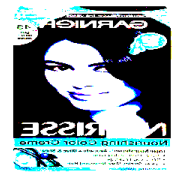

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


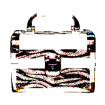

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


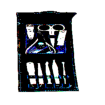

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


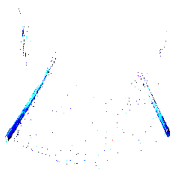

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


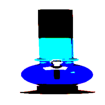

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


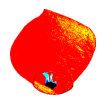

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


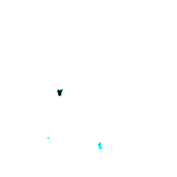

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


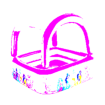

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


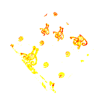

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


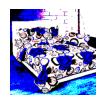

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


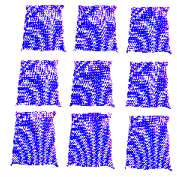

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


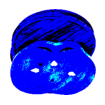

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


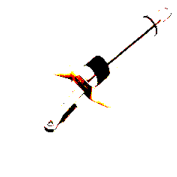

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


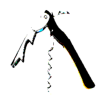

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


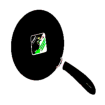

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


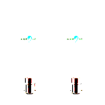

In [51]:
plot_images(misclassified_imgs['BeautyAndPersonalCare'],0)
plot_images(misclassified_imgs['HomeDecorAndFestiveNeeds'],0)
plot_images(misclassified_imgs['BabyCare'],0)
plot_images(misclassified_imgs['HomeFurnishing'],0)
plot_images(misclassified_imgs['KitchenandDining'],0)



In [52]:
def undo_preprocessing(x):
    mean = [103.939, 116.779, 123.68]
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    x = x[..., ::-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


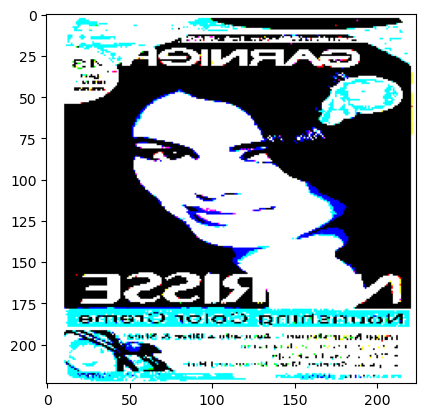

In [53]:
img = misclassified_imgs['BeautyAndPersonalCare'][0]
plt.imshow(img)
plt.show()

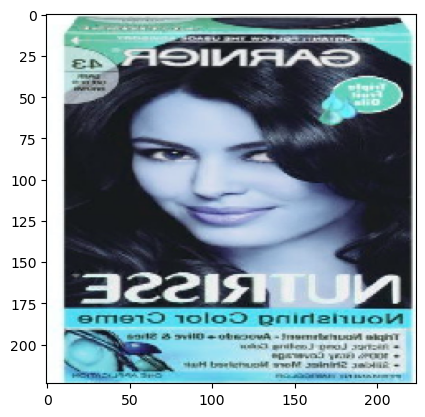

In [54]:
import copy
new_img = copy.copy(img)
undo_preprocessing(new_img)
plt.imshow(new_img.astype('int'))
plt.show()

In [56]:
def plot_images_2(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        img_unproc = copy.copy(img)
        undo_preprocessing(img_unproc)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img_unproc.astype('int'))
        plt.axis('off')
        plt.show()

BeautyAndPersonalCare


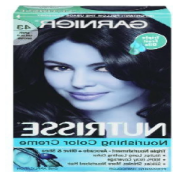

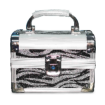

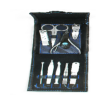

HomeDecorAndFestiveNeeds


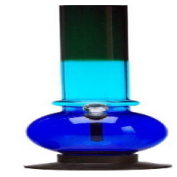

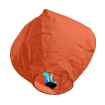

BabyCare


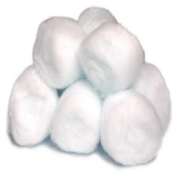

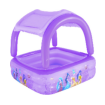

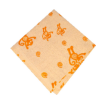

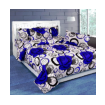

HomeFurnishing


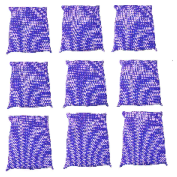

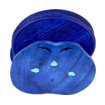

KitchenandDining


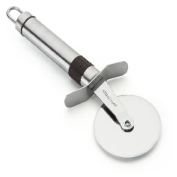

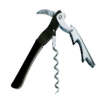

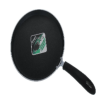

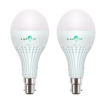

Watches, Computers : 0


In [154]:
print('BeautyAndPersonalCare')
plot_images_2(misclassified_imgs['BeautyAndPersonalCare'],0)
print('HomeDecorAndFestiveNeeds')
plot_images_2(misclassified_imgs['HomeDecorAndFestiveNeeds'],0)
print('BabyCare')
plot_images_2(misclassified_imgs['BabyCare'],0)
print('HomeFurnishing')
plot_images_2(misclassified_imgs['HomeFurnishing'],0)
print('KitchenandDining')
plot_images_2(misclassified_imgs['KitchenandDining'],0)

print('Watches, Computers : 0')

In [153]:
### attention, on n'a pas cleané la dataset original. On ne sait pas si l'équipe avait bien répertorié chaque article.
## cela peut induire des erreurs dans le training set.
## voir cet article pour voir comment faire : https://thedatafrog.com/fr/articles/dogs-vs-cats/